# Regional Analysis

In the last notebooks we've seen how to query data for a single Area of Interest.

In this section we want to scale up the analysis and compare different regions with each other. Since datacubes provide access to global datasets, scaling up is just a matter of changing the area of interest. For the planned analysis we want to gather data for all of Austria, which has an area of around 84.000 km². Just for comparison, all of Austria is more than 8 times larger than northern Tyrol, which means that for FSC and WDS over 800 million unique datapoints have to be handled to carry out the analysis. Even analysis at this size is possible with datacubes.

With Sentinel Hub there are convenience APIs available to apply an analysis which already works on a single geometry to many geometries. This makes it very easy to scale up and use the full potential of a datacube. These APIs are:

- Batch Processing API
- Batch Statistical API

For this use case we are using the Batch Statistical API.

In [2]:
import logging
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

from sentinelhub import (
    DataCollection,
    SentinelHubBatchStatistical,
    SentinelHubStatistical,
    SHConfig,
    monitor_batch_statistical_job,
    Geometry,
    CRS
)

### Disclaimer

For this analysis an Enterprise account on Sentinel Hub is necessary. You also need to have access to an AWS S3 Bucket in which the data will be saved. 

More information about using Batch APIs can be found [here](https://docs.sentinel-hub.com/api/latest/api/batch-statistical/). Currently the AWS integration in the sentinelhub package is also not supported on the default EoXhub kernel. The following cell can thus not be run straight out of the box. However when using the services locally outside of EDC the cell can be run using the same credentials you'd use on EDC ([see here](https://eurodatacube.com/documentation/credentials-on-edc)). Another option is to specify a custom kernel as described [here](https://eurodatacube.com/documentation/custom-jupyter-kernels).

However you can still run the analysis since the data which was generated through the requests is available to the notebook.

In [2]:
from credentials import AWS_ID, AWS_SECRET

from sentinelhub.aws.batch import AwsBatchStatisticalResults
from sentinelhub.data_utils import get_failed_statistical_requests, statistical_to_dataframe

config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]
config.aws_access_key_id = AWS_ID
config.aws_secret_access_key = AWS_SECRET

## Loading area of interest

In this case we are loading a file containing the different states in Austria. 

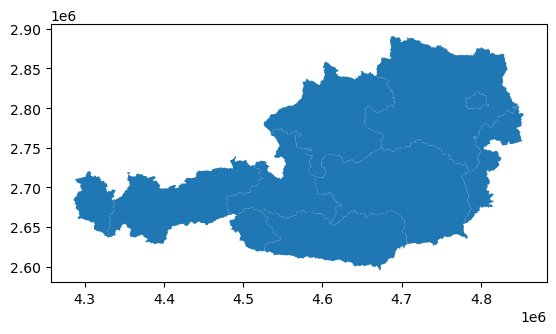

In [3]:
# Load in austrian states
states = gpd.read_file("input/austria_states.geojson")
# simplify geom to pass into payload 
states = states.set_geometry(states.simplify(100))
states["identifier"] = states.BL
crs_epsg = states.crs.to_epsg()
geom = states.geometry[0]
geom_sh = Geometry(geom, CRS(3035))
states.plot();

### Exporting data for use with statistical API

Batch statistical API works asynchronosly, which means that it runs entirely on the cloud and is also saving the results to the cloud.

Because of this the input data also has to be accessible on the cloud. This is why we export the data here in a format that can be used by the statistical API. This data is then uploaded onto the cloud which we want to perform the analysis on.

In [4]:
states["geometry"] = [MultiPolygon([feature]) if isinstance(feature, Polygon) \
    else feature for feature in states["geometry"]]

gpkg = "input/austria_states.gpkg"
for geomtype in states.geom_type.unique():
   states[states.geom_type == geomtype].to_file(gpkg, driver="GPKG", layer=geomtype)

## Defining used data

Here we are defining the data we want to use. For this example we just want to generate maps of Persistent Snow Area and timeseries of Fractional Snow Cover for each state.

In [79]:
config.sh_base_url = "https://creodias.sentinel-hub.com"
psa = DataCollection.define_byoc("da7e0012-8c43-42db-a5dc-cfd606c8b2dd")
gfsc = DataCollection.define_byoc("e0e66010-ab8a-46d5-94bd-ae5c750e7341")
config.sh_base_url = "https://services.sentinel-hub.com"

## Persistent Snow Area

For this analysis we want to get the following data:

- The persistent snow area in each region and for each year

Using the Batch Statistical API gives a few key advantages:

- Ability to specifiy a custom aggregation interval
- Automatic application to the different polygons in the file
- Asynchronous computation completely in the cloud

In [9]:
with open("input/eval_psa_stat.js", "r") as file:
    evalscript = file.read()

aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=("2016-01-01", "2022-01-01"),
    aggregation_interval="P1Y",
    resolution=(100, 100),
)

input_data=[
    SentinelHubStatistical.input_data(
        data_collection=psa,
    )
]

### Creating the request and logging the status

In [12]:
INPUT_PATH = "s3://etc-datacubes-batch/austria_states.gpkg"
OUTPUT_PATH = "s3://etc-datacubes-batch/psa/"
input_features = SentinelHubBatchStatistical.s3_specification(INPUT_PATH, AWS_ID, AWS_SECRET)
output = SentinelHubBatchStatistical.s3_specification(OUTPUT_PATH, AWS_ID, AWS_SECRET)

client = SentinelHubBatchStatistical(config)
request = client.create(
    input_features=input_features,
    input_data=input_data,
    aggregation=aggregation,
    output=output,
    calculations={}
)
client.start_job(request)

In [15]:
# To get the full output we must configure the logger first
logging.basicConfig(level=logging.INFO)

monitor_batch_statistical_job(request, config=config, analysis_sleep_time=60)

INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status ANALYSING, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job is running
Completion percentage: 100%|██████████| 100/100 [08:04<00:00,  4.85s/it]


{'id': '42709b19-8984-4487-be5d-b30a6e30484e',
 'status': 'DONE',
 'completionPercentage': 100,
 'lastUpdated': '2023-01-19T08:28:25.780427Z',
 'costPU': 101.25044806551273,
 'created': '2023-01-19T08:14:34.115687Z'}

### Getting the data

In [16]:
LOCAL_FOLDER = "output"

result_ids = range(1, 10) 
batch_results_request = AwsBatchStatisticalResults(
    request, data_folder=LOCAL_FOLDER, feature_ids=result_ids, config=config
)
results = batch_results_request.get_data(save_data=True, max_threads=4, show_progress=True)
df = statistical_to_dataframe(results)
df.to_csv("./output/psa_states.csv")

/home/jviehweger/Documents/Projects/2023/projects/ETC/WP4_19_Datacubes/Technical/.venv/lib/python3.10/site-packages/sentinelhub/base.py:180: SHDeprecationWarning: Class `AwsDownloadClient` has been deprecated. It will remain in the codebase for now, but won't be actively maintained.
  client = self.download_client_class(
100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


### Analysis of changes in persistent snow area

First we can take a look at the data we got back from the request to the datacube.

In [3]:
df = pd.read_csv("./output/psa_states.csv", parse_dates=['interval_from'])
df.head()

,Unnamed: 0,persistent_snow_B0_min,persistent_snow_B0_max,persistent_snow_B0_mean,persistent_snow_B0_stDev,persistent_snow_B0_sampleCount,persistent_snow_B0_noDataCount,interval_from,interval_to,identifier
0,0,0.0,1.0,0.002440,0.049338,1437780,479657,2017-01-01 00:00:00+00:00,2018-01-01 00:00:00+00:00,Kärnten
1,1,0.0,1.0,0.001843,0.042890,1437780,479554,2018-01-01 00:00:00+00:00,2019-01-01 00:00:00+00:00,Kärnten
2,2,0.0,1.0,0.002961,0.054332,1437780,479554,2019-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00,Kärnten
3,3,0.0,1.0,0.002734,0.052220,1437780,479610,2020-01-01 00:00:00+00:00,2021-01-01 00:00:00+00:00,Kärnten
4,4,0.0,1.0,0.003189,0.056383,1437780,479554,2021-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,Kärnten


Here we prepare the data for analysis. From the statistical output we calculate the number of pixels covered with persistent snow and from that we derive the hectares which are covered.

To analyse it we select two years to compare and compute the percentage change for them.

In [4]:
year1 = 2018
year2 = 2021
df["year"] = df["interval_from"].dt.year
df["count_snow"] = df["persistent_snow_B0_mean"]*df["persistent_snow_B0_sampleCount"]
df["ha_snow"] = (df["count_snow"]).astype(int)
df["state"] = df["identifier"]
df_subset = df.iloc[np.isin(df["year"], [year1, year2])]
diff = pd.pivot_table(df_subset, values = "ha_snow", index = ["year", "state"], aggfunc=np.sum).unstack("year").reset_index()
diff.columns = ["state", year1, year2]
diff["percent_change"] = (diff[year2] / diff[year1])*100
diff

,state,2018,2021,percent_change
0,Burgenland,0,0,NaN
1,Kärnten,2649,4585,173.084183
2,Niederösterreich,0,1,inf
3,Oberösterreich,201,547,272.139303
4,Salzburg,6101,11603,190.181937
5,Steiermark,4,150,3750.000000
6,Tirol,24406,41528,170.154880
7,Vorarlberg,804,576,71.641791
8,Wien,0,0,NaN


We can already see that in most regions the persistent snow area has increased, however let's plot a map to have it more visual:

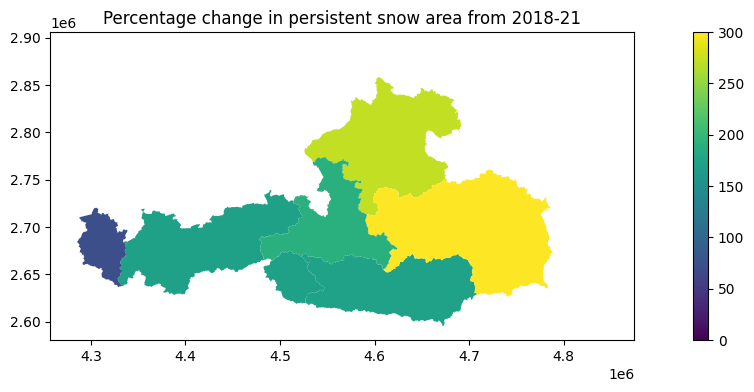

In [11]:
merged = states.merge(diff, left_on="BL", right_on="state")
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title("Percentage change in persistent snow area from 2018-21");
merged.plot(column="percent_change", vmin=0, vmax=300, legend=True, ax=ax);

Here we can see that except for Vorarlberg all regions have increased the PSA in the analysed time frame. A big outlier is Styria, which has an increase in PSA of over 3000%, however since the total area is quite small to begin with, this relative change isn't very meaningful.

## Fractional Snow Cover time series

As another example mainly to show the power of being able to specify a time interval for aggregation we are analysing differences in the fractional snow cover over the regions.

This analysis is made really easy because the aggregation interval can be set to monthly, which is almost all the changes that are needed to get analysis ready data. The steps of creating the request, monitoring the progress and getting the data stays exactly the same.

In this case we are getting monthly data for the snow season 2017-2018.

In [97]:
with open("input/eval_fsc_stat.js", "r") as file:
    evalscript_fsc = file.read()

aggregation_fsc = SentinelHubStatistical.aggregation(
    evalscript=evalscript_fsc,
    time_interval=("2017-11-01", "2018-06-01"),
    aggregation_interval="P1M",
    resolution=(100, 100),
)

input_data_fsc=[
    SentinelHubStatistical.input_data(
        data_collection=gfsc,
    )
]

OUTPUT_PATH_FSC = "s3://etc-datacubes-batch/fsc/"
output_fsc = SentinelHubBatchStatistical.s3_specification(OUTPUT_PATH_FSC, AWS_ID, AWS_SECRET)

### Creating the request and logging the status

In [98]:
request_fsc = client.create(
    input_features=input_features,
    input_data=input_data_fsc,
    aggregation=aggregation_fsc,
    output=output_fsc,
    calculations={}
)
client.start_job(request_fsc)

''

In [99]:
# To get the full output we must configure the logger first
logging.basicConfig(level=logging.INFO)

monitor_batch_statistical_job(request_fsc, config=config, analysis_sleep_time=60)

INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status ANALYSING, sleeping for 60 seconds
Completion percentage: 100%|██████████| 100/100 [45:10<00:00, 27.10s/it]


{'id': 'c928b2d1-5ebe-43b8-9f30-dd2778d63a22',
 'status': 'DONE',
 'completionPercentage': 100,
 'lastUpdated': '2023-01-19T12:59:01.703758Z',
 'costPU': 8763.529687748236,
 'created': '2023-01-19T12:12:00.422554Z'}

### Getting the data

In [102]:
LOCAL_FOLDER = "output"

result_ids = range(1, 10) 
batch_results_request = AwsBatchStatisticalResults(
    request_fsc, data_folder=LOCAL_FOLDER, feature_ids=result_ids, config=config
)
results = batch_results_request.get_data(save_data=True, max_threads=4, show_progress=True)

/home/jviehweger/Documents/Projects/2023/projects/ETC/WP4_19_Datacubes/Technical/.venv/lib/python3.10/site-packages/sentinelhub/base.py:180: SHDeprecationWarning: Class `AwsDownloadClient` has been deprecated. It will remain in the codebase for now, but won't be actively maintained.
  client = self.download_client_class(
100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


### Analysis of fractional snow cover time series

First we are taking a look at the data we got back from the request to the datacube.

In [103]:
df_fsc = statistical_to_dataframe(results)
df_fsc.to_csv("./output/fsc_states.csv")
df_fsc.head()

,fractional_snow_B0_min,fractional_snow_B0_max,fractional_snow_B0_mean,fractional_snow_B0_stDev,fractional_snow_B0_sampleCount,fractional_snow_B0_noDataCount,interval_from,interval_to,identifier
0,0.0,1.0,0.377477,0.484756,1437780,917301,2017-11-01 00:00:00+00:00,2017-12-01 00:00:00+00:00,Kärnten
1,0.0,1.0,0.823326,0.381392,1437780,1373475,2017-12-01 00:00:00+00:00,2018-01-01 00:00:00+00:00,Kärnten
2,0.0,1.0,0.742158,0.437447,1437780,1258298,2018-01-01 00:00:00+00:00,2018-02-01 00:00:00+00:00,Kärnten
3,0.0,1.0,0.882256,0.322305,1437780,1258298,2018-02-01 00:00:00+00:00,2018-03-01 00:00:00+00:00,Kärnten
4,0.0,1.0,0.906757,0.290773,1437780,1373475,2018-03-01 00:00:00+00:00,2018-04-01 00:00:00+00:00,Kärnten


Here we prepare the data for analysis. From the statistical output we calculate the number of pixels covered with snow in each month and derive the number of square kilometers as well as the percent of the geometry covered by snow.

In [12]:
df_fsc = pd.read_csv("./output/fsc_states.csv", parse_dates=['interval_from'])
df_fsc["month"] = df_fsc["interval_from"].dt.month
df_fsc["count_snow"] = df_fsc["fractional_snow_B0_mean"]*df_fsc["fractional_snow_B0_sampleCount"]
df_fsc["km2_snow"] = (0.1*0.1*df_fsc["count_snow"]).astype(int)
df_fsc["percent_covered"] = df_fsc["fractional_snow_B0_mean"]
df_fsc["state"] = df_fsc["identifier"]

Finally we can plot the evolution of snow cover for different Austrian states in the snow season 2017-18.

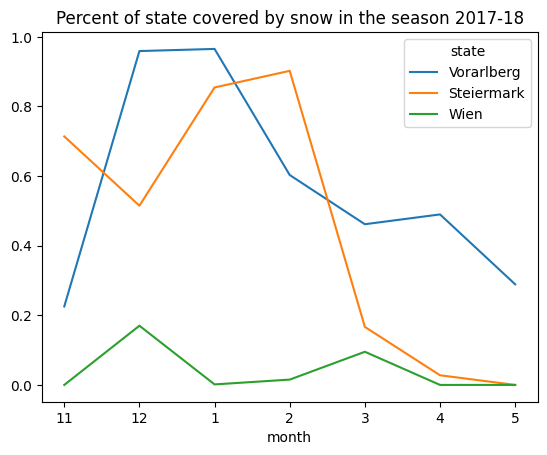

In [13]:
fsc = df_fsc[["percent_covered", "state", "month"]]
fsc_mth = pd.pivot_table(fsc, values="percent_covered", index=["state", "month"]).unstack(0)
fsc_mth.columns = fsc_mth.columns.droplevel()

months = np.arange(1,13)
idx = np.roll(months, 7)
replace = {A: B for A, B in zip(months, idx)}

fsc_mth["month"] = fsc_mth.index
fsc_mth.index = fsc_mth.index.astype(str)
fsc_mth["id"] = fsc_mth["month"].replace(replace)
fsc_mth.sort_values("id").plot(y=["Vorarlberg", "Steiermark", "Wien"], title="Percent of state covered by snow in the season 2017-18");

As expected Vienna is covered very seldomly by snow. Also in this season Styria lost it's snow cover earlier than Vorarlberg. With most snow being gone already in March.

## Summary Batch Statistical

- Utility function to easily scale up analysis that already works on a small scale
- Works in the background and completely on the cloud
- Works at any scale. Even continental or global analysis is possible

## General Technical Summary

- No preprocessing necessary (resolution, time frame, AOI)
- Multiple data sources
- Application of high level concepts:
  - Spatial aggregation
  - Temporal aggregation
- Directly getting Analysis Ready Data
- Scaling up easily